### GenreBot : Using Natural Language Processing in Music Marketing

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition](./01_data_acquisition.ipynb)
- [Data Cleaning](./02_data_cleaning.ipynb)
- [Exploratory Data Analysis](./03_eda.ipynb)
- Modeling (this notebook)
- [Experiments](./04a_experiments.ipynb)
- [Results and Recommendations](./05_results.ipynb)

**In this notebook, you'll find a variety of NLP modeling technique, including:**
- Stemming/lemmatizing
- Text vectorization using word counts and TFIDF (Term Frequency - Inverse Document Frequency)
- Classification using basic logistic regression, K-nearest neighbors, and multinomial naive Bayes
- Tree-based classification including single decision tree, bagged decision trees, random forests, ExtraTrees, AdaBoost, and gradient boosting
- Heterogeneous aggregated modeling via stacking
- Model selection via GridSearchCV

**Assumptions/approach:**
- We will hone in on solid stemming/lemmatization/vectorization parameters early on and keep those for the remainder of our modeling attempts.
- Although we kept capitalization in our text column for later analysis, we will lower-case for vectorization.
- There is no useful feature engineering to be done here - we're just using 1 text column and 1 target column.
- We don't need to scale our features, since they're all on the same scale.
- We will use accuracy as our primary metric. The rationale here is that our classes are quite well-balanced due to the data acquisition process; and, they are equivalent to each other in terms of how "high stakes" a "false positive" or a "false negative" would be. So, there's no reason to optimize for sensitivity or specificity, or employ balanced accuracy - regular accuracy will be fine.
- I did try using RandomizedSearchCV rather than GridSearchCV to reduce hyperparameter tuning time, but found that it decreased scores too much to be worthwhile.
- Based on early trials, we can immediately start with English stop words, so we will set that at the beginning.
- Our eventual goal is to find the most performant model with a testing accuracy score over **80%**.
- Although we downloaded posts for 4 subreddits, we will stick with 2 to keep this a binary classification problem for now. Based on our EDA and general sense of the data, we will try **classicalmusic** and **jazz**.

In [91]:
# usual imports
import pandas as pd
import numpy as np
import time

# infrastructure
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

# transformers
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

# supervised
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

# heterogeneous-model supervised
from sklearn.ensemble import StackingClassifier

# evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score

In [92]:
# Read in our clean data

df = pd.read_csv('../data/clean_posts.csv')

In [93]:
# Remind ourselves what it looks like

df.head()

,author,created_utc,id,num_comments,score,selftext,subreddit,title,period,all_text,all_text_len,all_text_word_len
0,discord,1221835135,72cy3,16,5,NaN,jazz,Anyone know of any dark / evil sounding jazz?,1,Anyone know of any dark evil sounding jazz,42,8
1,smacfarl,1222039404,72p6u,5,0,NaN,jazz,In honor of Soil &amp; Pimp showing us how it'...,1,In honor of Soil Pimp showing us how it's done...,114,21
2,[deleted],1223963408,76zmj,2,2,NaN,jazz,anybody have that record of Charlie Christian ...,1,anybody have that record of Charlie Christian ...,145,26
3,smacfarl,1224683862,78nrr,4,5,NaN,jazz,New Topline Image for Jazz subreddit. Suggesti...,1,New Topline Image for Jazz subreddit Suggestio...,73,11
4,ChefEspeff,1235783273,80wtq,10,2,NaN,jazz,"Teaching yourself Jazz Piano, is it possible?",1,Teaching yourself Jazz Piano is it possible,43,7


In [94]:
# We're focusing on just 2 classes, so let's drop the others
df = df[(df['subreddit'] == 'classicalmusic') | (df['subreddit'] == 'jazz')]
df.shape

(19937, 12)

In [95]:
# let's encode our classes for efficiency
# https://benalexkeen.com/mapping-categorical-data-in-pandas/
df['subreddit_code'] = df['subreddit'].astype('category').cat.codes

- We'll now set up our X (**all_text**) and y (**subreddit**), and perform our usual train-test split with stratification over the 2 classes to ensure equivalent distributions of classical vs. jazz in train and test.
- We'll double-check the sizes of our results for sanity.

In [96]:
X = df['all_text']
y = df['subreddit_code']

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14952,), (4985,), (14952,), (4985,))

In [98]:
y_train.value_counts(normalize = True)

0    0.500468
1    0.499532
Name: subreddit_code, dtype: float64

In [99]:
y_test.value_counts(normalize = True)

0    0.500502
1    0.499498
Name: subreddit_code, dtype: float64

**Conclusions:**
- We have reduced our classes to 2, and they're well distributed in both train and test.
- Our train and test sizes are about 15,000 and 5,000 respectively, as we would expect from our downloaded data.
- Next, we'll set up a couple of useful functions for testing stemming and lemmatization, and for evaluating our results.

In [100]:
# Thanks to https://stackoverflow.com/questions/57340142/user-warning-your-stop-words-may-be-inconsistent-with-your-preprocessing
# for the idea of including stopword tokenization in the stemmer/lemmatizer to keep things consistent

STOP_WORDS = stopwords.words('english')

# function to implement PorterStemmer as a possible tokenizer for our vectorizers as we GridSearch
def stemmer(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens if token not in STOP_WORDS]

In [101]:
# function to implement WordNetLemmatizer as a possible tokenizer for our vectorizers as we GridSearch
def lemmatizer(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens if token not in STOP_WORDS]

In [107]:
# data frame for storing our stats
df_stats = pd.DataFrame(columns = ['model', 'fit_time', 'train_acc', 'test_acc', 'recall', 'precision', 'f1'])

# Thanks to Devin Fay and his Imbalanced Data lesson at GA for the basis of this function
def evaluation(model, model_desc, X_train, y_train, X_test, y_test, normalize = 'pred'):
    '''
    Function to print and acquire some quick model stats.

    Parameters:
        model: the model
        model: description of the model
        X_train, y_train: Training features and target
        X_test, y_test: Testing features and target
        normalize: normalization for ConfusionMatrixDisplay
    Returns:
        Dataframe containing the model, fit time, training accuracy, testing accuracy, recall, precision, and F1
    '''

    start_time = time.time()
    model.fit(X_train, y_train)
    stop_time = time.time()
    fit_time = stop_time - start_time
    preds = model.predict(X_test)
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues',
    normalize=normalize)

    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    recall = recall_score(y_test, preds, pos_label = 1)
    precision = precision_score(y_test, preds, pos_label = 1)
    f1 = f1_score(y_test, preds, pos_label = 1)
    
    print(f'fit time: {fit_time}')
    print(f'training set accuracy: {train_acc}')
    print(f'test set accuracy: {test_acc}')
    print(f'recall: {recall}')
    print(f'precision: {precision}')
    print(f'f1 score: {f1}')

    return pd.DataFrame([{'model': model_desc, 'fit_time': fit_time, 'train_acc': train_acc, 'test_acc': test_acc,
        'recall': recall, 'precision': precision, 'f1': f1}])
    

**Model 1: CountVectorizer + "vanilla" LogisticRegression:**
- We're purposely keeping the LogisticRegression parameters simple so that we can focus on the performance of the CountVectorizer, including stemming and lemmatizing.

fit time: 0.8740048408508301
training set accuracy: 0.9752541466024612
test set accuracy: 0.9317953861584755
recall: 0.9120481927710843
precision: 0.9494147157190636
f1 score: 0.9303564113068413


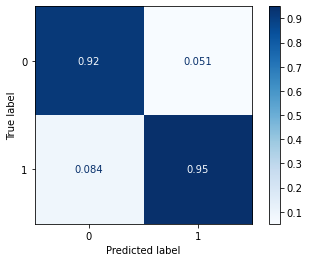

In [108]:
pipe = Pipeline(steps = [('cvec', CountVectorizer()), ('logreg', LogisticRegression(max_iter = 10_000))])

pipe_params = {
    'cvec__tokenizer': [None, stemmer, lemmatizer],
    'cvec__max_features': [3000, 4000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [0.8, 0.9],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

gs = GridSearchCV(estimator = pipe, param_grid = pipe_params, n_jobs = -1)
gs.fit(X_train, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'CountVectorizer + LogisticRegression', X_train, y_train, X_test, y_test)])

In [104]:
gs.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.8, max_features=4000, min_df=2)),
                ('logreg', LogisticRegression(max_iter=10000))])

**Hot take:**
- As is often the case, logistic regression is almost unexpectedly strong. We've already got a model that exceeds our success threshold of 80% accuracy on the testing set!
- Final fit took less than a second, so it's pretty efficient as well.
- Interesting that GridSearch did not choose stemming or lemmatization

**Model 2: TfidfVectorizer + "vanilla" LogisticRegression:**
- We're purposely keeping the LogisticRegression parameters simple so that we can focus on the performance of the TfidfVectorizer, including stemming and lemmatizing.

fit time: 1.4952263832092285
training set accuracy: 0.956995719636169
test set accuracy: 0.9368104312938816
recall: 0.9176706827309237
precision: 0.954070981210856
f1 score: 0.9355168884339816


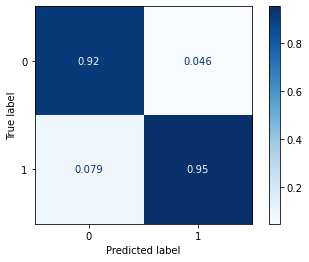

In [110]:
pipe = Pipeline(steps = [('tfidf', TfidfVectorizer()), ('logreg', LogisticRegression(max_iter = 10_000))])

pipe_params = {
    'tfidf__tokenizer': [None, stemmer, lemmatizer],
    'tfidf__stop_words': [None, 'english'],
    'tfidf__max_features': [3000, 4000],
    'tfidf__min_df': [1, 2],
    'tfidf__max_df': [0.8, 0.9],
    'tfidf__ngram_range': [(1, 1), (1, 2)]
}

gs = GridSearchCV(estimator = pipe, param_grid = pipe_params, n_jobs = -1)
gs.fit(X_train, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'TfidfVectorizer + LogisticRegression', X_train, y_train, X_test, y_test)])

In [111]:
gs.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=4000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('logreg', LogisticRegression(max_iter=10000))])

**Hot Take:**
- Another excellent set of scores, same neighborhood as Model 1
- Still quite efficient, just over a second
- Interesting that GridSearch did not choose stemming or lemmatization
- I would tend to prefer this model over Model 1 - I'm willing to give up a tiny bit of bias to close the variance gap a bit

**Model 3: TFIDF + tuned LogisticRegression**
- Now that we have a sense of the best transformation/vectorization parameters, we can focus on tuning the estimator itself.
- Note that all the warnings below are expected due to incompatible permutations of LogisticRegression parameters. They can safely be ignored.

c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
270 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, s

fit time: 4.055915355682373
training set accuracy: 0.9552568218298555
test set accuracy: 0.9380140421263792
recall: 0.9184738955823293
precision: 0.9557041370664437
f1 score: 0.9367192299815685


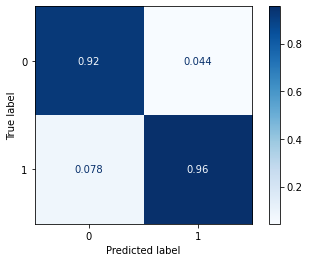

In [112]:
pipe = Pipeline(steps = [('tfidf', TfidfVectorizer(max_df=0.8, max_features=4000, ngram_range=(1, 2),
                stop_words='english')), ('logreg', LogisticRegression(max_iter = 10_000))])

pipe_params = {
    'logreg__penalty': ['None', 'l1', 'l2', 'elasticnet'],
    'logreg__C': [0.1, 1, 10],
    'logreg__solver': ['lbfgs', 'liblinear', 'saga'],
    'logreg__l1_ratio': [0.1, 0.5, 1.0]
}

gs = GridSearchCV(estimator = pipe, param_grid = pipe_params, n_jobs = -1)
gs.fit(X_train, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'TfidfVectorizer + tuned LogisticRegression', X_train, y_train, X_test, y_test)])

In [113]:
gs.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=4000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('logreg',
                 LogisticRegression(C=1, l1_ratio=0.1, max_iter=10000,
                                    penalty='elasticnet', solver='saga'))])

**Hot Take:**
- A tiny improvement over Model 2
- Final fit took almost 4x as long as Model 2
- Worth keeping for stacking

**Model 4: TfidfVectorizer + K-nearest neighbors**
- Time to move on to new estimators! Let's give KNN a shot.

fit time: 1.4645106792449951
training set accuracy: 0.9948501872659176
test set accuracy: 0.6036108324974925
recall: 0.3301204819277108
precision: 0.727433628318584
f1 score: 0.45414364640883975


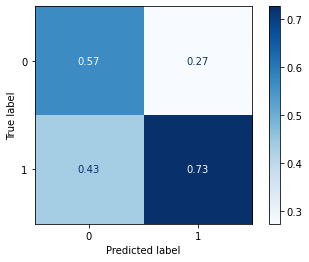

In [114]:
pipe = Pipeline(steps = [('tfidf', TfidfVectorizer(max_df=0.8, max_features=4000, ngram_range=(1, 2),
                stop_words='english')), ('knn', KNeighborsClassifier())])

pipe_params = {
    'knn__n_neighbors': [3, 5, 8],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'manhattan', 'euclidean']
}

gs = GridSearchCV(estimator = pipe, param_grid = pipe_params, n_jobs = -1)
gs.fit(X_train, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'TfidfVectorizer + KNN', X_train, y_train, X_test, y_test)])

In [115]:
gs.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=4000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('knn',
                 KNeighborsClassifier(n_neighbors=8, weights='distance'))])

**Hot Take:**
- As I kind of expected, this one's pretty bad - hugely overfit, and the precision/recall/F1 aren't nearly as good
- About as fast as Model 2
- Not worth keeping

**Model 5: TfidfVectorizer + Multinomial Naive Bayes**

fit time: 1.2961556911468506
training set accuracy: 0.9414125200642055
test set accuracy: 0.9279839518555667
recall: 0.9257028112449799
precision: 0.9298104074223478
f1 score: 0.9277520627892937


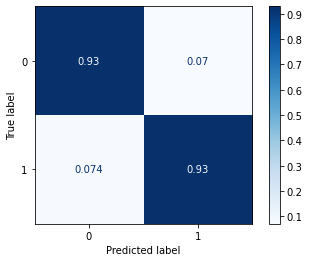

In [116]:
pipe = Pipeline(steps = [('tfidf', TfidfVectorizer(max_df=0.8, max_features=4000, ngram_range=(1, 2),
                stop_words='english')), ('mnb', MultinomialNB())])

pipe_params = {
    'mnb__alpha': [0.0, 0.4, 0.8, 1.0]
}

gs = GridSearchCV(estimator = pipe, param_grid = pipe_params, n_jobs = -1)
gs.fit(X_train, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'TFIDF + MultinomialNB', X_train, y_train, X_test, y_test)])

In [117]:
gs.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=4000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('mnb', MultinomialNB())])

**Hot Take:**
- Really does very well, almost as good as our LogisticRegressions
- About as fast to fit as Model 2
- Worth keeping for stacking

**Model 6: TFIDF + Single Decision Tree**

fit time: 1.618755578994751
training set accuracy: 0.8120652755484216
test set accuracy: 0.7993981945837513
recall: 0.6096385542168675
precision: 0.981888745148771
f1 score: 0.7522299306243806


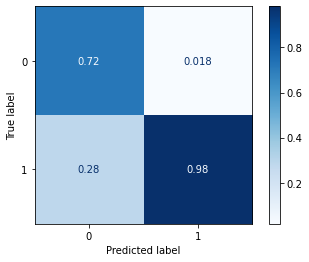

In [118]:
pipe = Pipeline(steps = [('tfidf', TfidfVectorizer(max_df=0.8, max_features=4000, ngram_range=(1, 2),
                stop_words='english')), ('dt', DecisionTreeClassifier(random_state = 42))])

pipe_params = {
    'dt__max_features': [3000, 4000],
    'dt__max_depth': [2, 5, 10],
    'dt__min_samples_split': [2, 4],
    'dt__min_samples_leaf': [1, 2]
}

gs = GridSearchCV(estimator = pipe, param_grid = pipe_params, n_jobs = -1)
gs.fit(X_train, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'TfidfVectorizer + DecisionTree', X_train, y_train, X_test, y_test)])

In [119]:
gs.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=4000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('dt',
                 DecisionTreeClassifier(max_depth=10, max_features=3000,
                                        min_samples_leaf=2, random_state=42))])

**Hot Take:**
- Not as bad as I thought, but definitely higher bias than our other models
- Reasonably fast to fit
- Not worth keeping

**Model 7: TFIDF + Bagged Decision Trees**

fit time: 28.87225651741028
training set accuracy: 0.9923756019261637
test set accuracy: 0.9063189568706118
recall: 0.8847389558232932
precision: 0.9244649601342845
f1 score: 0.9041658116150215


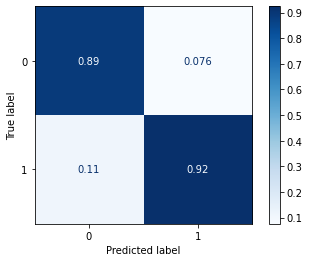

In [121]:
pipe = Pipeline(steps = [('tfidf', TfidfVectorizer(max_df=0.8, max_features=4000, ngram_range=(1, 2),
                stop_words='english')), ('bag', BaggingClassifier(random_state = 42))])

pipe_params = {
    'bag__n_estimators': [10, 20]
}

gs = GridSearchCV(estimator = pipe, param_grid = pipe_params, n_jobs = -1)
gs.fit(X_train, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'TfidfVectorizer + Bagging', X_train, y_train, X_test, y_test)])

In [122]:
gs.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=4000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('bag', BaggingClassifier(n_estimators=20, random_state=42))])

**Hot Take:**
- Really pretty good scores, not as good as Model 2/3
- Very slow fit!
- Not worth keeping

**Model 8: TFIDF + Random Forest**

fit time: 2.6281583309173584
training set accuracy: 0.9144596040663456
test set accuracy: 0.9033099297893681
recall: 0.8413654618473896
precision: 0.96012832263978
f1 score: 0.8968321917808219


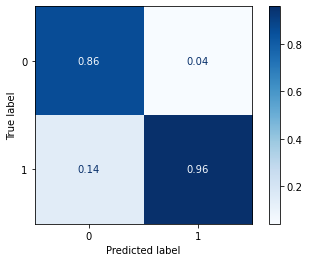

In [123]:
pipe = Pipeline(steps = [('tfidf', TfidfVectorizer(max_df=0.8, max_features=4000, ngram_range=(1, 2),
                stop_words='english')), ('rf', RandomForestClassifier(random_state = 42))])

pipe_params = {
    'rf__n_estimators': [100, 150],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__max_depth': [2, 5, 10],
    'rf__min_samples_split': [2, 4],
    'rf__min_samples_leaf': [1, 2]
}

gs = GridSearchCV(estimator = pipe, param_grid = pipe_params, n_jobs = -1)
gs.fit(X_train, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'TfidfVectorizer + Random Forest', X_train, y_train, X_test, y_test)])

In [124]:
gs.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=4000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        n_estimators=150, random_state=42))])

**Hot Take:**
- Pretty good scores, not as good as Model 2/3
- About 2x as slow to fit as Model 2/3
- Not worth keeping

**Model 9: TFIDF + ExtraTrees**

fit time: 1.85849928855896
training set accuracy: 0.9217495987158909
test set accuracy: 0.9117352056168505
recall: 0.8975903614457831
precision: 0.9235537190082644
f1 score: 0.910386965376782


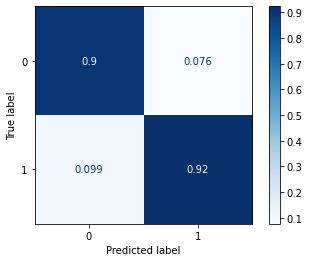

In [125]:
pipe = Pipeline(steps = [('tfidf', TfidfVectorizer(max_df=0.8, max_features=4000, ngram_range=(1, 2),
                stop_words='english')), ('et', ExtraTreesClassifier(random_state = 42))])

pipe_params = {
    'et__n_estimators': [100, 150],
    'et__max_features': ['sqrt', 'log2'],
    'et__max_depth': [2, 5, 10],
    'et__min_samples_split': [2, 4],
    'et__min_samples_leaf': [1, 2]
}

gs = GridSearchCV(estimator = pipe, param_grid = pipe_params, n_jobs = -1)
gs.fit(X_train, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'TfidfVectorizer + ExtraTrees', X_train, y_train, X_test, y_test)])

In [126]:
gs.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=4000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('et',
                 ExtraTreesClassifier(max_depth=10, min_samples_split=4,
                                      n_estimators=150, random_state=42))])

**Hot Take:**
- Pretty comparable to other tree ensembles, not as good as Model 2/3
- Reasonably fast fit
- Not worth keeping

**Model 10: TFIDF + AdaBoost**

fit time: 7.388280153274536
training set accuracy: 0.9004815409309791
test set accuracy: 0.8952858575727182
recall: 0.8321285140562249
precision: 0.9522058823529411
f1 score: 0.8881268752678955


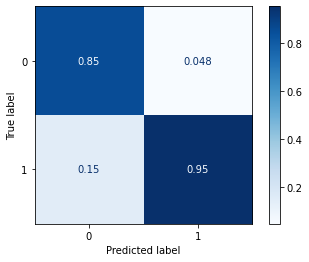

In [127]:
pipe = Pipeline(steps = [('tfidf', TfidfVectorizer(max_df=0.8, max_features=4000, ngram_range=(1, 2),
                stop_words='english')), ('ada', AdaBoostClassifier(random_state = 42))])

pipe_params = {
    'ada__n_estimators': [50, 100],
    'ada__learning_rate': [1, 5, 10]
}

gs = GridSearchCV(estimator = pipe, param_grid = pipe_params, n_jobs = -1)
gs.fit(X_train, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'TfidfVectorizer + AdaBoost', X_train, y_train, X_test, y_test)])

In [128]:
gs.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=4000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('ada',
                 AdaBoostClassifier(learning_rate=1, n_estimators=100,
                                    random_state=42))])

**Hot Take:**
- Comparable to tree ensembles, not as good as Model 2/3
- Slow fit
- Not worth keeping

**Model 11: TFIDF + GradientBoost**

fit time: 2.4219231605529785
training set accuracy: 0.933119315141787
test set accuracy: 0.9245737211634905
recall: 0.8835341365461847
precision: 0.9623797025371829
f1 score: 0.9212730318257957


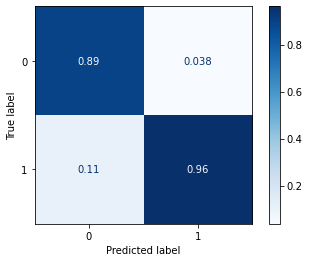

In [129]:
pipe = Pipeline(steps = [('tfidf', TfidfVectorizer(max_df=0.8, max_features=4000, ngram_range=(1, 2),
                stop_words='english')), ('grad', GradientBoostingClassifier(random_state = 42))])

pipe_params = {
    'grad__n_estimators': [100, 150],
    'grad__subsample': [0.7, 1.0],
    'grad__learning_rate': [0.1, 1, 10],
    'grad__max_features': ['sqrt', 'log2'],
    'grad__max_depth': [3, 5, 10],
    'grad__min_samples_split': [2, 4],
    'grad__min_samples_leaf': [1, 2]
}

gs = GridSearchCV(estimator = pipe, param_grid = pipe_params, n_jobs = -1)
gs.fit(X_train, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'TfidfVectorizer + GradientBoost', X_train, y_train, X_test, y_test)])

In [130]:
gs.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=4000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('grad',
                 GradientBoostingClassifier(max_depth=10, max_features='log2',
                                            min_samples_leaf=2,
                                            n_estimators=150, random_state=42,
                                            subsample=0.7))])

**Hot Take:**
- Pretty decent, a bit better than AdaBoost, still not as good as Model 2/3
- About 2x as slow to fit as Model 2/3
- Worth keeping for stacking

**Model 12: LogisticRegression/MultinomialNB/GradientBoost Stack**
- This model and the 3 following it are various Stacking permutations of our 3 favorite models
- Trying to see if aggregating 3 heterogeneous well-performing models leads to any meaningful performance gains

fit time: 15.63344120979309
training set accuracy: 0.9527822364901016
test set accuracy: 0.9376128385155467
recall: 0.9269076305220884
precision: 0.9470660648338121
f1 score: 0.9368784250050742


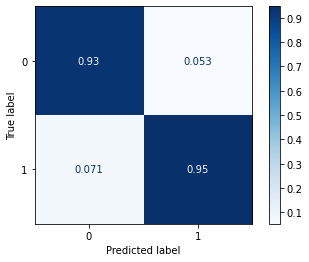

In [131]:
# Set up TFIDF vectorization first
tfidf = TfidfVectorizer(max_df=0.8, max_features=4000, ngram_range=(1, 2), stop_words='english')
X_vec_train = tfidf.fit_transform(X_train)
X_vec_test = tfidf.transform(X_test)

logreg = LogisticRegression(C=1, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
mnb = MultinomialNB()
grad = GradientBoostingClassifier(max_depth=10, max_features='log2',
                           min_samples_leaf=2, n_estimators=150,
                           random_state=42, subsample = 0.7)

l1_estimators = [('logreg', logreg), ('mnb', mnb), ('grad', grad)]

stack = StackingClassifier(l1_estimators)
df_stats = pd.concat([df_stats, evaluation(stack, 'TfidfVectorizer + LogReg/MNB/Grad Stack', X_vec_train, y_train, X_vec_test, y_test)])

**Hot Take:**
- Not quite as good as Model 2/3, but close!
- Slow to fit

**Model 13: MultinomialNB/GradientBoost Stack**

fit time: 4.41567325592041
training set accuracy: 0.9456928838951311
test set accuracy: 0.9319959879638917
recall: 0.9228915662650602
precision: 0.939877300613497
f1 score: 0.931306990881459


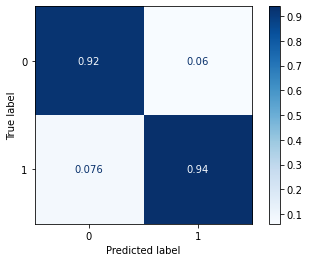

In [132]:
tfidf = TfidfVectorizer(max_df = 0.8, max_features = 4000, stop_words = 'english')
X_vec_train = tfidf.fit_transform(X_train)
X_vec_test = tfidf.transform(X_test)

mnb = MultinomialNB()
grad = GradientBoostingClassifier(max_depth=10, max_features='log2',
                           min_samples_leaf=2, n_estimators=150,
                           random_state=42, subsample = 0.7)

l1_estimators = [('mnb', mnb), ('grad', grad)]

stack = StackingClassifier(l1_estimators)
df_stats = pd.concat([df_stats, evaluation(stack, 'TfidfVectorizer + MNB/Grad stack', X_vec_train, y_train, X_vec_test, y_test)])

**Hot Take:**
- Not quite as good as our first stack
- A lot faster than our first stack
- Probably not worth keeping

**Model 14: LogisticRegression/GradientBoost Stack**

fit time: 14.953498363494873
training set accuracy: 0.9576645264847512
test set accuracy: 0.9372116349047142
recall: 0.9224899598393574
precision: 0.9503516756309475
f1 score: 0.9362135724475239


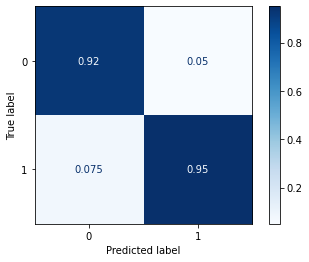

In [133]:
tfidf = TfidfVectorizer(max_df = 0.8, max_features = 4000, stop_words = 'english')
X_vec_train = tfidf.fit_transform(X_train)
X_vec_test = tfidf.transform(X_test)

logreg = LogisticRegression(C=1, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
mnb = MultinomialNB()
grad = GradientBoostingClassifier(max_depth=10, max_features='log2',
                           min_samples_leaf=2, n_estimators=150,
                           random_state=42, subsample = 0.7)

l1_estimators = [('logreg', logreg), ('grad', grad)]

stack = StackingClassifier(l1_estimators)
df_stats = pd.concat([df_stats, evaluation(stack, 'TfidfVectorizer + Logreg/Grad stack', X_vec_train, y_train, X_vec_test, y_test)])

**Hot Take:**
- Pretty comparable to our first stack, still not quite as good as Model 2/3
- Slow to fit
- Probably not worth keeping

**Model 15: LogisticRegression/MultinomialNB Stack**

fit time: 10.6922926902771
training set accuracy: 0.9572632423756019
test set accuracy: 0.9414242728184554
recall: 0.9317269076305221
precision: 0.95004095004095
f1 score: 0.9407948094079481


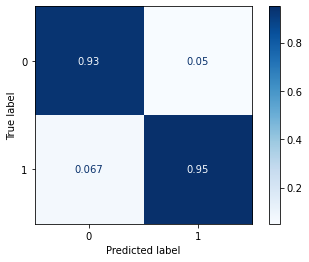

In [134]:
tfidf = TfidfVectorizer(max_df = 0.8, max_features = 4000, stop_words = 'english')
X_vec_train = tfidf.fit_transform(X_train)
X_vec_test = tfidf.transform(X_test)

logreg = LogisticRegression(C=1, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
mnb = MultinomialNB()

l1_estimators = [('logreg', logreg), ('mnb', mnb)]

stack = StackingClassifier(l1_estimators)
df_stats = pd.concat([df_stats, evaluation(stack, 'TfidfVectorizer + Logreg/MNB stack', X_vec_train, y_train, X_vec_test, y_test)])

**Hot Take:**
- Probably our best stack
- Slow to fit
- Maybe worth keeping!

In [135]:
# Let's see our compiled model stats

df_stats

,model,fit_time,train_acc,test_acc,recall,precision,f1
0,CountVectorizer + LogisticRegression,0.874005,0.975254,0.931795,0.912048,0.949415,0.930356
0,TfidfVectorizer + LogisticRegression,1.495226,0.956996,0.93681,0.917671,0.954071,0.935517
0,TfidfVectorizer + tuned LogisticRegression,4.055915,0.955257,0.938014,0.918474,0.955704,0.936719
0,TfidfVectorizer + KNN,1.464511,0.99485,0.603611,0.33012,0.727434,0.454144
0,TFIDF + MultinomialNB,1.296156,0.941413,0.927984,0.925703,0.92981,0.927752
0,TfidfVectorizer + DecisionTree,1.618756,0.812065,0.799398,0.609639,0.981889,0.75223
0,TfidfVectorizer + Bagging,28.872257,0.992376,0.906319,0.884739,0.924465,0.904166
0,TfidfVectorizer + Random Forest,2.628158,0.91446,0.90331,0.841365,0.960128,0.896832
0,TfidfVectorizer + ExtraTrees,1.858499,0.92175,0.911735,0.89759,0.923554,0.910387
0,TfidfVectorizer + AdaBoost,7.38828,0.900482,0.895286,0.832129,0.952206,0.888127


In [142]:
# Apply our success rubric - nobody with < 80% test accuracy is eligible

df_stats = df_stats[df_stats['test_acc'] >= 0.8]

df_stats

,model,fit_time,train_acc,test_acc,recall,precision,f1
0,CountVectorizer + LogisticRegression,0.874005,0.975254,0.931795,0.912048,0.949415,0.930356
1,TfidfVectorizer + LogisticRegression,1.495226,0.956996,0.93681,0.917671,0.954071,0.935517
2,TfidfVectorizer + tuned LogisticRegression,4.055915,0.955257,0.938014,0.918474,0.955704,0.936719
4,TFIDF + MultinomialNB,1.296156,0.941413,0.927984,0.925703,0.92981,0.927752
6,TfidfVectorizer + Bagging,28.872257,0.992376,0.906319,0.884739,0.924465,0.904166
7,TfidfVectorizer + Random Forest,2.628158,0.91446,0.90331,0.841365,0.960128,0.896832
8,TfidfVectorizer + ExtraTrees,1.858499,0.92175,0.911735,0.89759,0.923554,0.910387
9,TfidfVectorizer + AdaBoost,7.38828,0.900482,0.895286,0.832129,0.952206,0.888127
10,TfidfVectorizer + GradientBoost,2.421923,0.933119,0.924574,0.883534,0.96238,0.921273
11,TfidfVectorizer + LogReg/MNB/Grad Stack,15.633441,0.952782,0.937613,0.926908,0.947066,0.936878


In [143]:
# Oops we need to reset the index to something reasonable

df_stats.index = range(0, 13)
df_stats

# Looking better

,model,fit_time,train_acc,test_acc,recall,precision,f1
0,CountVectorizer + LogisticRegression,0.874005,0.975254,0.931795,0.912048,0.949415,0.930356
1,TfidfVectorizer + LogisticRegression,1.495226,0.956996,0.93681,0.917671,0.954071,0.935517
2,TfidfVectorizer + tuned LogisticRegression,4.055915,0.955257,0.938014,0.918474,0.955704,0.936719
3,TFIDF + MultinomialNB,1.296156,0.941413,0.927984,0.925703,0.92981,0.927752
4,TfidfVectorizer + Bagging,28.872257,0.992376,0.906319,0.884739,0.924465,0.904166
5,TfidfVectorizer + Random Forest,2.628158,0.91446,0.90331,0.841365,0.960128,0.896832
6,TfidfVectorizer + ExtraTrees,1.858499,0.92175,0.911735,0.89759,0.923554,0.910387
7,TfidfVectorizer + AdaBoost,7.38828,0.900482,0.895286,0.832129,0.952206,0.888127
8,TfidfVectorizer + GradientBoost,2.421923,0.933119,0.924574,0.883534,0.96238,0.921273
9,TfidfVectorizer + LogReg/MNB/Grad Stack,15.633441,0.952782,0.937613,0.926908,0.947066,0.936878


In [144]:
# Let's export!

df_stats.to_csv("../data/model_stats.csv", index = False)

**FINAL NOTES**
- The results of the retrieval are exported [here](../data/model_stats.csv).
- The next FORMAL notebook in the series is [Results and Recommendations](./05_results.ipynb).
- If you'd like to see a couple of experiments, check out [Experiments](./04a_experiments.ipynb).